# SIRD

**NB:** Set the argument `output_image` of the plotting functions to `False` when running the notebook to have interactive plots (some have a dropdown that allows to choose the province/region)

In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint

import lmfit

from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from plots import *
from utils import *
from sird import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

## Basic SIRD
Stochastic and continuous with logistic Rt

In [5]:
province = 'Firenze'

sirsol = sird(province, pop_prov_df)
S, I, R, D = sirsol

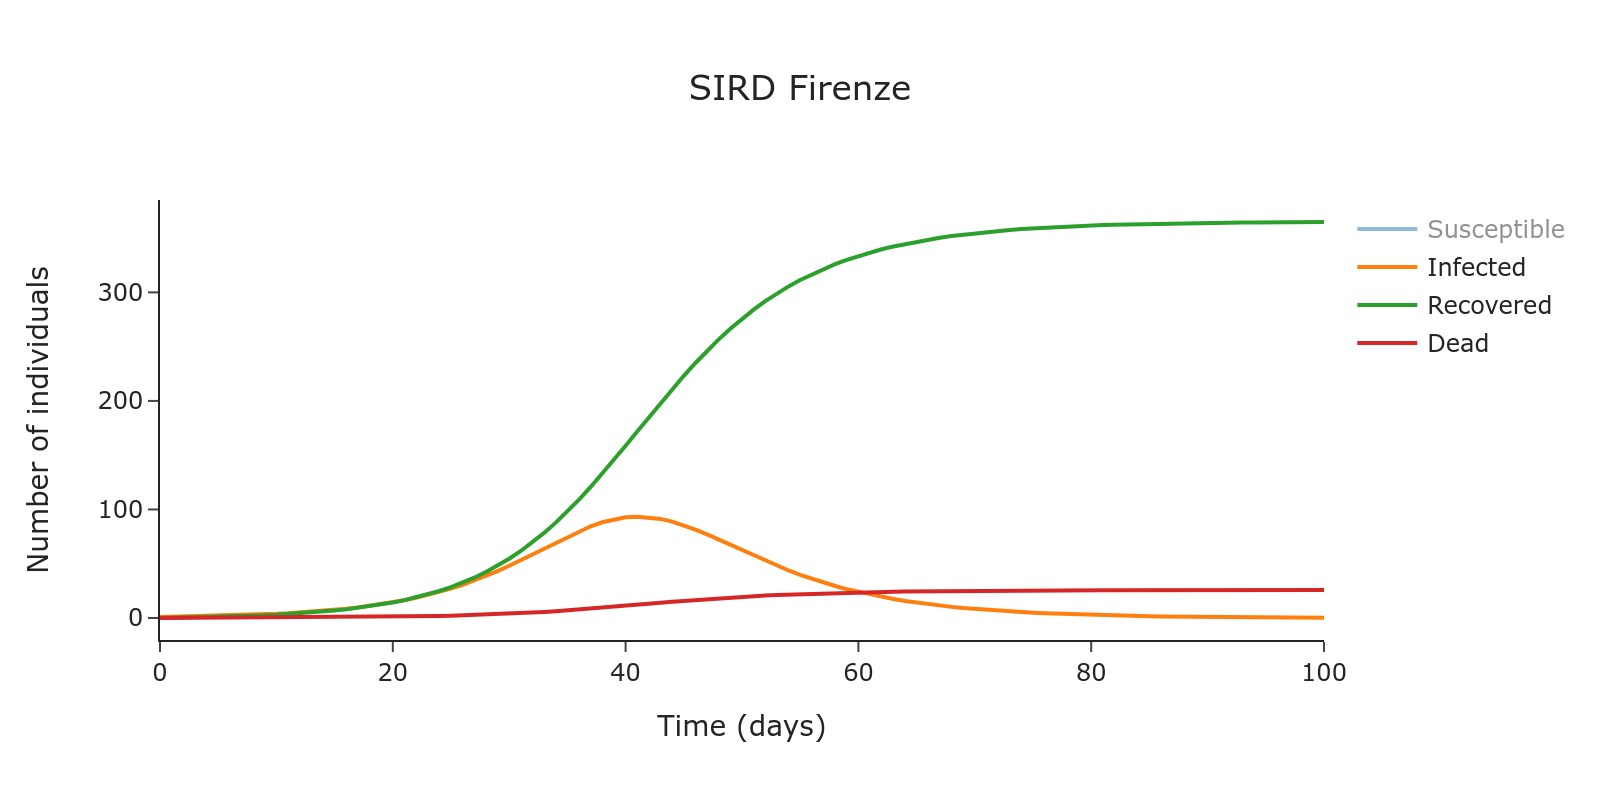

In [6]:
times = list(range(sirsol.shape[1]))

general_plot(t=times, 
             data=sirsol, 
             title='SIRD ' + province,
             traces_visibility=['legendonly'] + [True]*3,
             output_image=True,
             template='simple_white')

In [7]:
# Uncomment for interactive plots

#result = pd.DataFrame()
#for prov in covidpro_df.Province.unique():
#    S, I, R, D = sird(prov, pop_prov_df)
#    tmp = pd.DataFrame(np.column_stack([[prov]*len(S),range(len(S)),S,I,R,D]))
#    result = pd.concat([result, tmp])
#    
#result.columns = ["Province", "t", "S", "I", "R", "D"]
#result.reset_index(drop=True,inplace=True)

In [8]:
#inter_dropdown_plot(options=result.Province.unique(), 
#                    default_value='Firenze', 
#                    dropdown_label='Province',
#                    y=["S", "I", "R", "D"],
#                    legend_titles=['Susceptible', 'Infected', 'Recovered', 'Dead'],
#                    data=result,
#                    group_column='Province',
#                    x='t',
#                    title='COVID-19 trendlines of ',
#                    xtitle='Data',
#                    ytitle='Unità',
#                    traces_visibility=['legendonly',True,True,True],
#                    output_image=False)

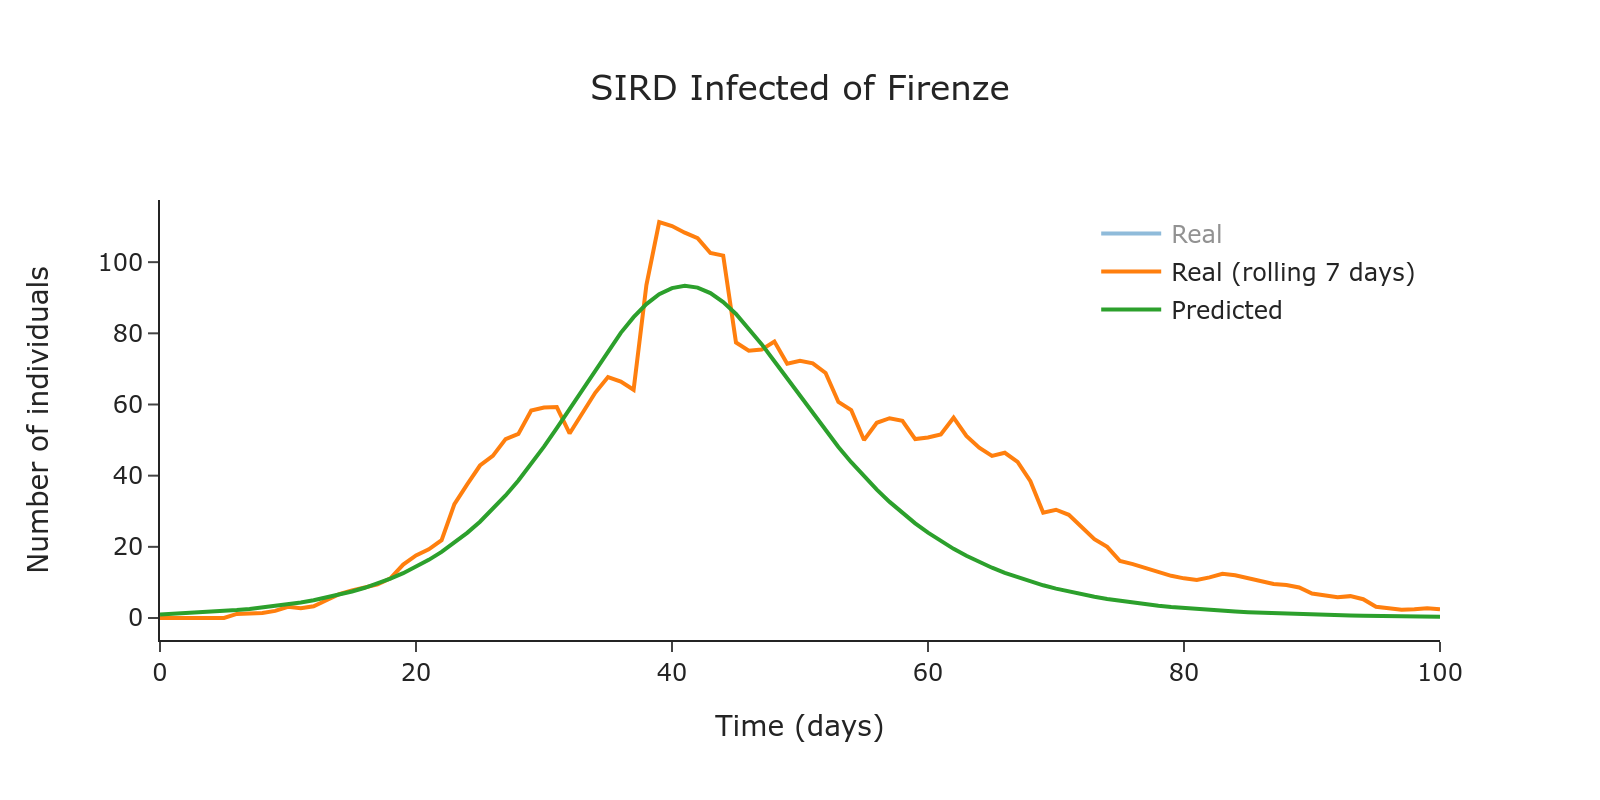

In [11]:
names, title, data, modes = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True],
             template='simple_white')

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(10.684018260735181, 198.36702622348741)

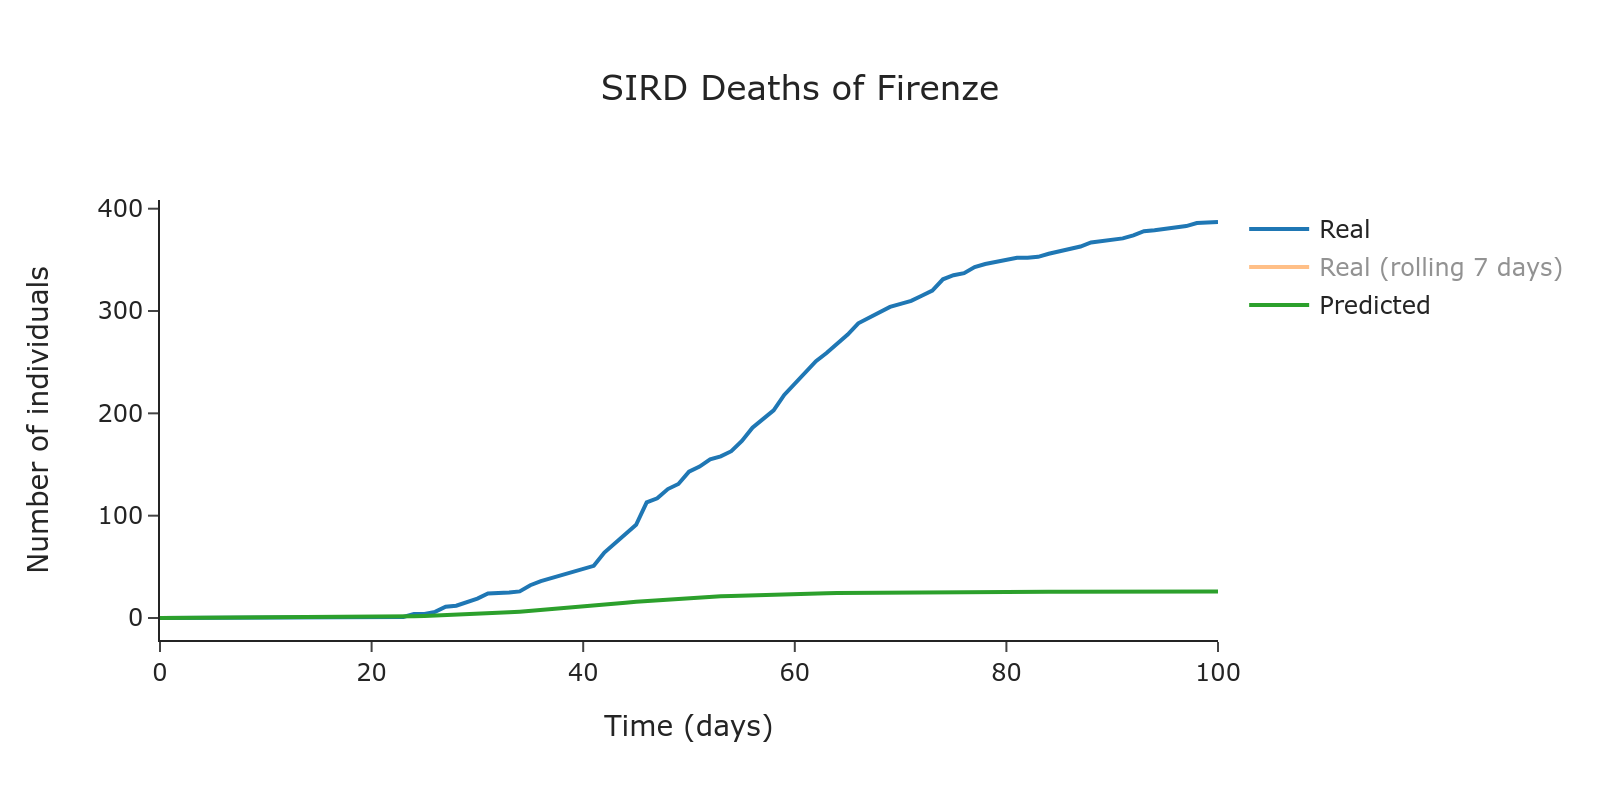

In [15]:
names, title, data, modes = data_for_plot('Deaths', covidpro_df, 'Tot_deaths', D, province)

general_plot(t=times,
             title=title,
             data=data, 
             names=names,
             modes=modes,
             blend_legend=False,
             output_image=True,
             traces_visibility=[True,'legendonly',True],
             template='simple_white')

In [16]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(139.89314833319267, 38803.593638986575)

In [17]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    _, I, _, _ = sird(prov, pop_prov_df)
    names, _, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, prov)
    tmp = pd.DataFrame(np.column_stack([[prov]*data[2].shape[0],range(data[2].shape[0]),data[0],data[1],data[2]]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "real", "real_roll", "pred"]
result.reset_index(drop=True,inplace=True)

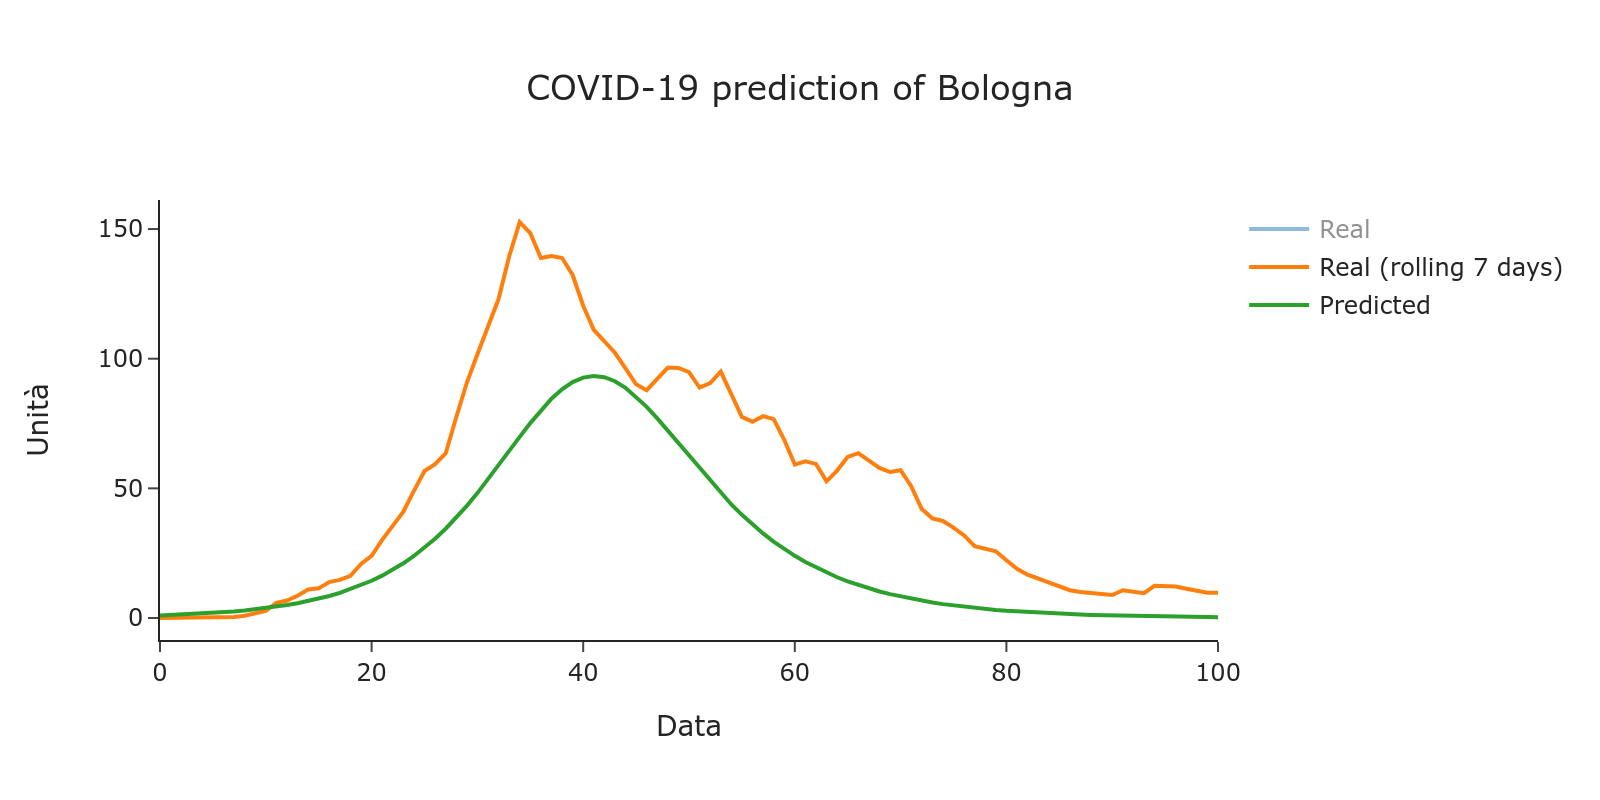

In [18]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Bologna', 
                    dropdown_label='Province',
                    y=["real", "real_roll", "pred"],
                    legend_titles=names,
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 prediction of ',
                    xtitle='Data',
                    ytitle='Unità',
                    output_image=True,
                    traces_visibility=['legendonly',True,True],
                    template='simple_white')

In [20]:
mean_absolute_error(result['real_roll'], result['pred']), mean_squared_error(result['real_roll'], result['pred'])

(20.664587861597848, 1242.5937448869945)

## Parameter estimation for logistic Rt
SIRD model fitting using least squares

In [22]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': 4,
    'Infected': 2
}

In [23]:
def fitter(x, R_0_start, k, x0, R_0_end, alpha, gamma):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, alpha, gamma)
    return ret[mapping[compart]][x]

In [24]:
def get_model(province, compart, data_df, pop_df, params_init_min_max=None, query='20200603 > Date', outbreak_shift=20, window=7):
    data = data_df[data_df.Province == province].query(query)[compart]
    if compart in ['New_cases', 'Deaths']:
        data = data.rolling(window).mean().fillna(0)
    
    N = pop_df.loc[(pop_df.Territorio == province) & (pop_df.Eta == "Total")]['Value'].values[0]

    # {parameter: (initial guess, min value, max value)}
    if params_init_min_max == None:
        params_init_min_max = {
            "R_0_start": (3.5, 1.0, 6),
            "k": (0.3, 0.01, 5.0),
            "x0": (20, 0, 100),
            "R_0_end": (0.9, 0.01, 3.5),
            "alpha": (0.1, 0.00000001, 1),
            "gamma": (1/7, 0.00000001, 1)
        }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

### Cumulative infected - Firenze
No outbreak shift

In [25]:
province = 'Firenze'
compart = 'Curr_pos_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [26]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [27]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 315
    # data points      = 100
    # variables        = 6
    chi-square         = 104885.665
    reduced chi-square = 1115.80494
    Akaike info crit   = 707.545594
    Bayesian info crit = 723.176615
[[Variables]]
    R_0_start:  4.00060097 +/- 15921.8921 (397987.51%) (init = 3.5)
    k:          0.08401433 +/- 0.00626347 (7.46%) (init = 0.3)
    x0:         18.4122033 +/- 2.33525570 (12.68%) (init = 20)
    R_0_end:    1.32125873 +/- 5259.92217 (398099.33%) (init = 0.9)
    alpha:      0.04520277 +/- 619.101855 (1369610.56%) (init = 0.1)
    gamma:      0.14015531 +/- 557.884284 (398047.20%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_end, alpha)     =  1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, R_0_end) =  1.000
    C(R_0_end, gamma)     = -1.000
    C(R_0_start, alpha)   =  1.000
    C(alpha, gamma)       = -1.000
    C(k, x0)              =  0.970


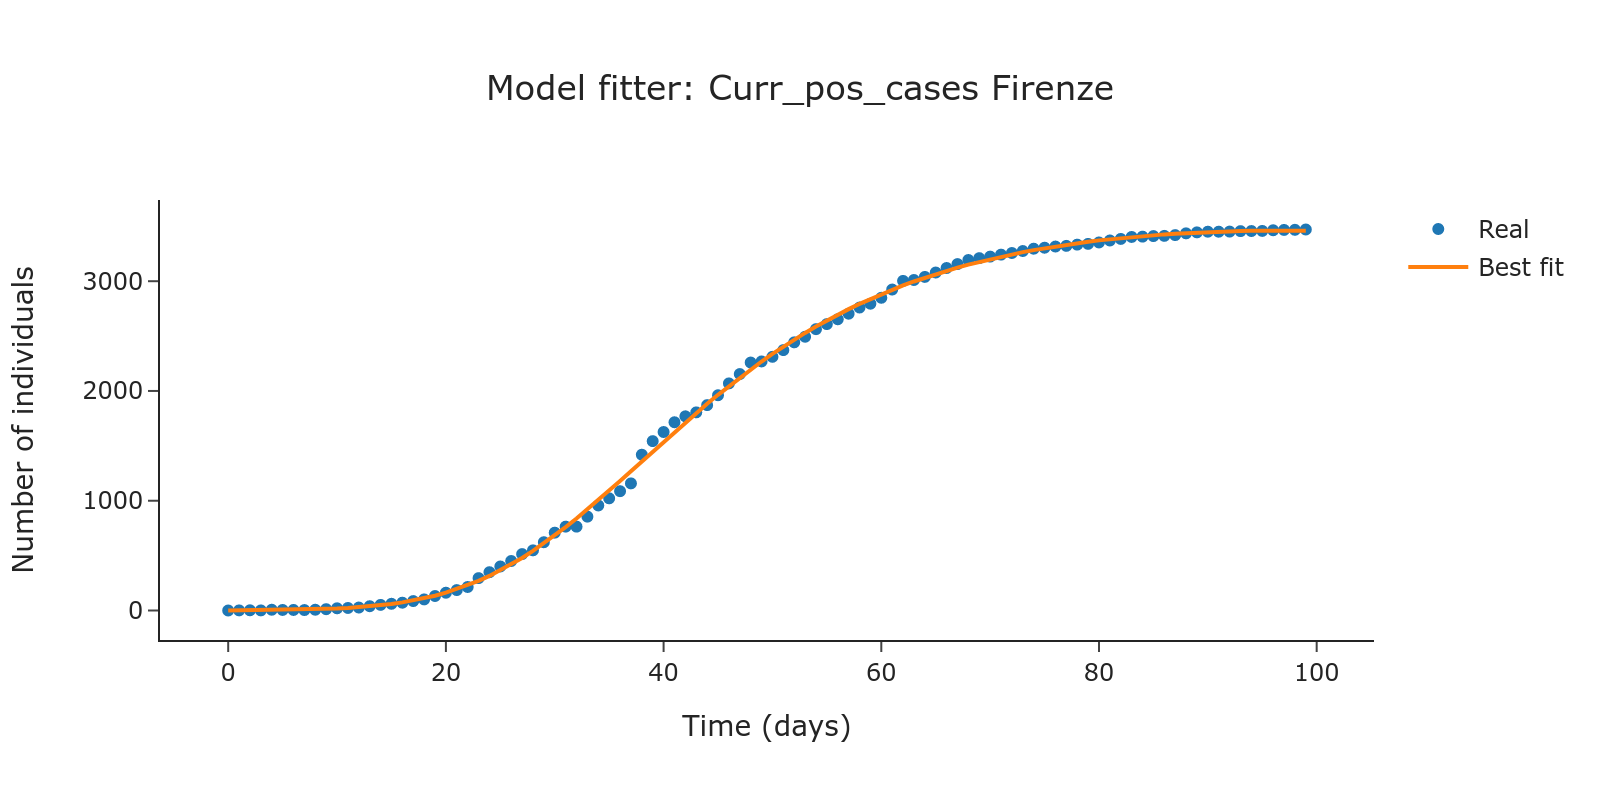

In [28]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [29]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(21.052558582188144, 1048.8566477536028)

In [30]:
result.best_values

{'R_0_start': 4.000600973282221,
 'k': 0.08401433194087307,
 'x0': 18.41220330012675,
 'R_0_end': 1.3212587303965662,
 'alpha': 0.045202765880996774,
 'gamma': 0.140155310496441}

### Daily infected - Firenze
No outbreak shift

In [31]:
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [32]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [33]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 467
    # data points      = 100
    # variables        = 6
    chi-square         = 5137.54834
    reduced chi-square = 54.6547696
    Akaike info crit   = 405.916108
    Bayesian info crit = 421.547129
[[Variables]]
    R_0_start:  3.05288038 +/- 413.392448 (13541.06%) (init = 3.5)
    k:          0.14421469 +/- 0.05549546 (38.48%) (init = 0.3)
    x0:         35.1144714 +/- 2.75302411 (7.84%) (init = 20)
    R_0_end:    1.75653544 +/- 62.2097625 (3541.62%) (init = 0.9)
    alpha:      0.21732658 +/- 47.6931081 (21945.36%) (init = 0.1)
    gamma:      0.16314855 +/- 46.7198532 (28636.39%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, gamma)   = -0.993
    C(alpha, gamma)       =  0.980
    C(R_0_start, alpha)   = -0.949
    C(x0, alpha)          = -0.934
    C(x0, gamma)          = -0.928
    C(k, alpha)           =  0.910
    C(R_0_start, x0)      =  0.906
    C(

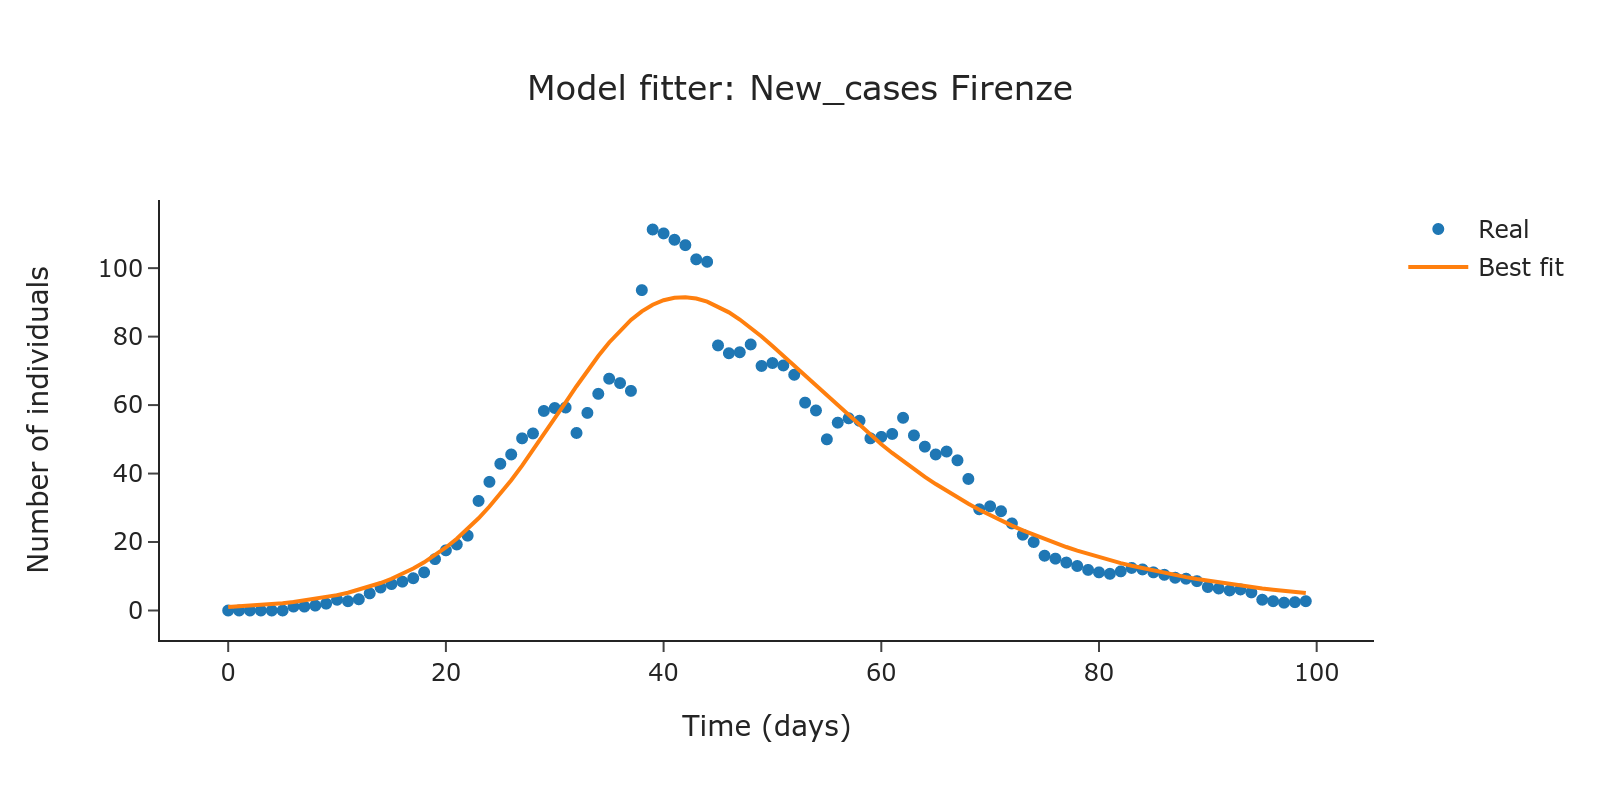

In [34]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [35]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(5.202194053266722, 51.37548343795631)

In [36]:
result.best_values

{'R_0_start': 3.052880378004642,
 'k': 0.1442146900847878,
 'x0': 35.11447143059068,
 'R_0_end': 1.7565354397122144,
 'alpha': 0.2173265751223985,
 'gamma': 0.16314855326415773}

In [37]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

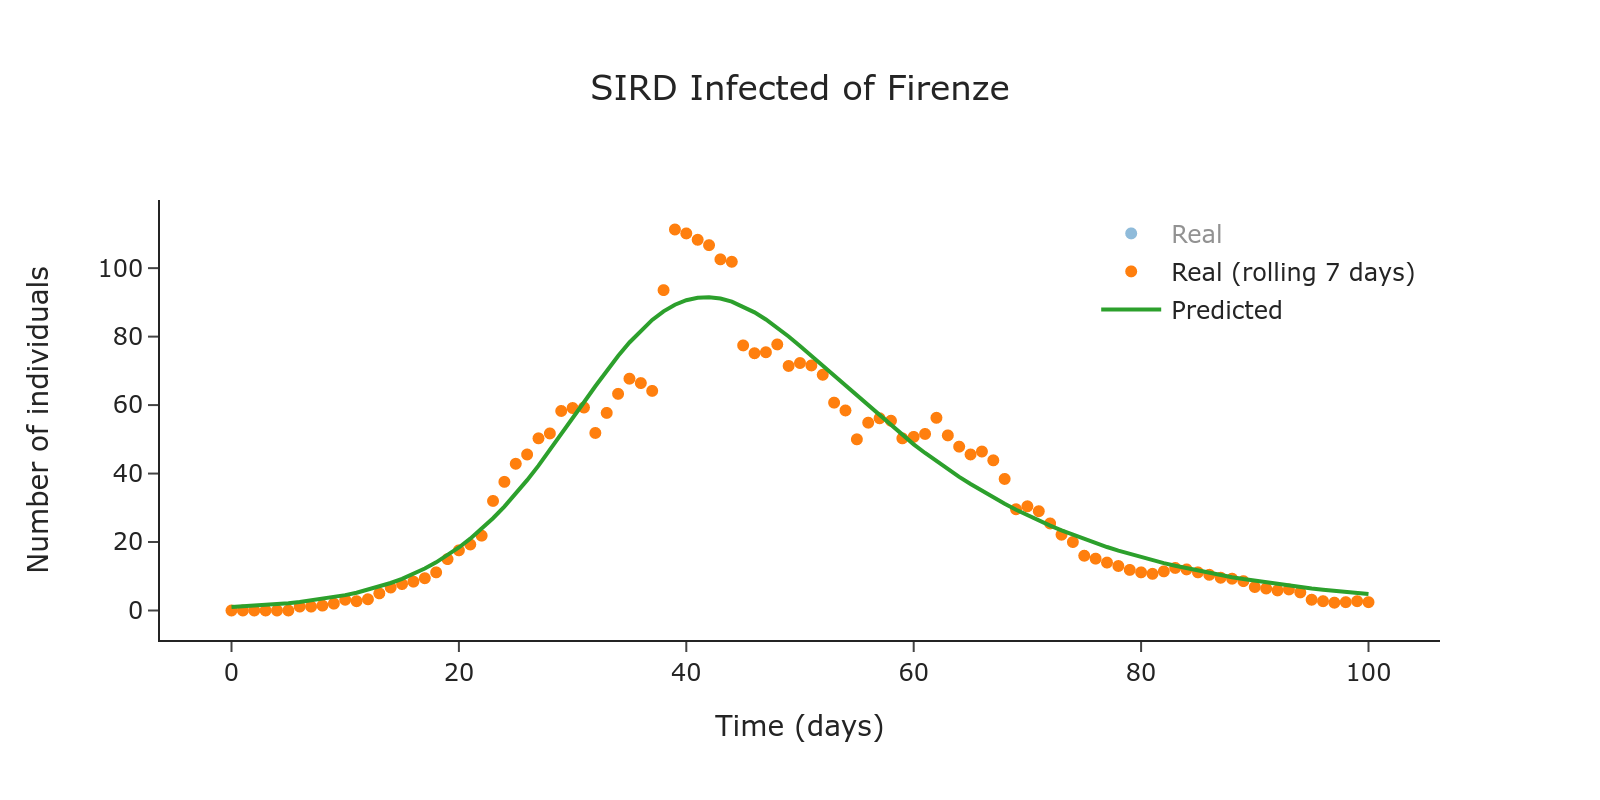

In [38]:
names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [39]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(5.174296292663379, 50.92311168845561)

### Daily infected - Firenze
Outbreak shift = 10

In [40]:
province = 'Firenze'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=10)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1262
    # data points      = 110
    # variables        = 6
    chi-square         = 5002.23991
    reduced chi-square = 48.0984607
    Akaike info crit   = 431.887678
    Bayesian info crit = 448.090560
[[Variables]]
    R_0_start:  4.05215671 +/- 1.31330311 (32.41%) (init = 3.5)
    k:          2.93264960 +/- 17.4557225 (595.22%) (init = 0.3)
    x0:         49.9246389 +/- 2.58447307 (5.18%) (init = 20)
    R_0_end:    3.50000000 +/- 1.26515891 (36.15%) (init = 0.9)
    alpha:      0.90631996 +/- 2.23885190 (247.03%) (init = 0.1)
    gamma:      0.25301505 +/- 0.45485163 (179.77%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma)       =  0.984
    C(k, x0)              = -0.929
    C(x0, alpha)          =  0.889
    C(k, alpha)           = -0.884
    C(x0, R_0_end)        =  0.828
    C(k, gamma)           = -0.812
    C(x0, gamma)          =  0.797
    C(k, R_0_

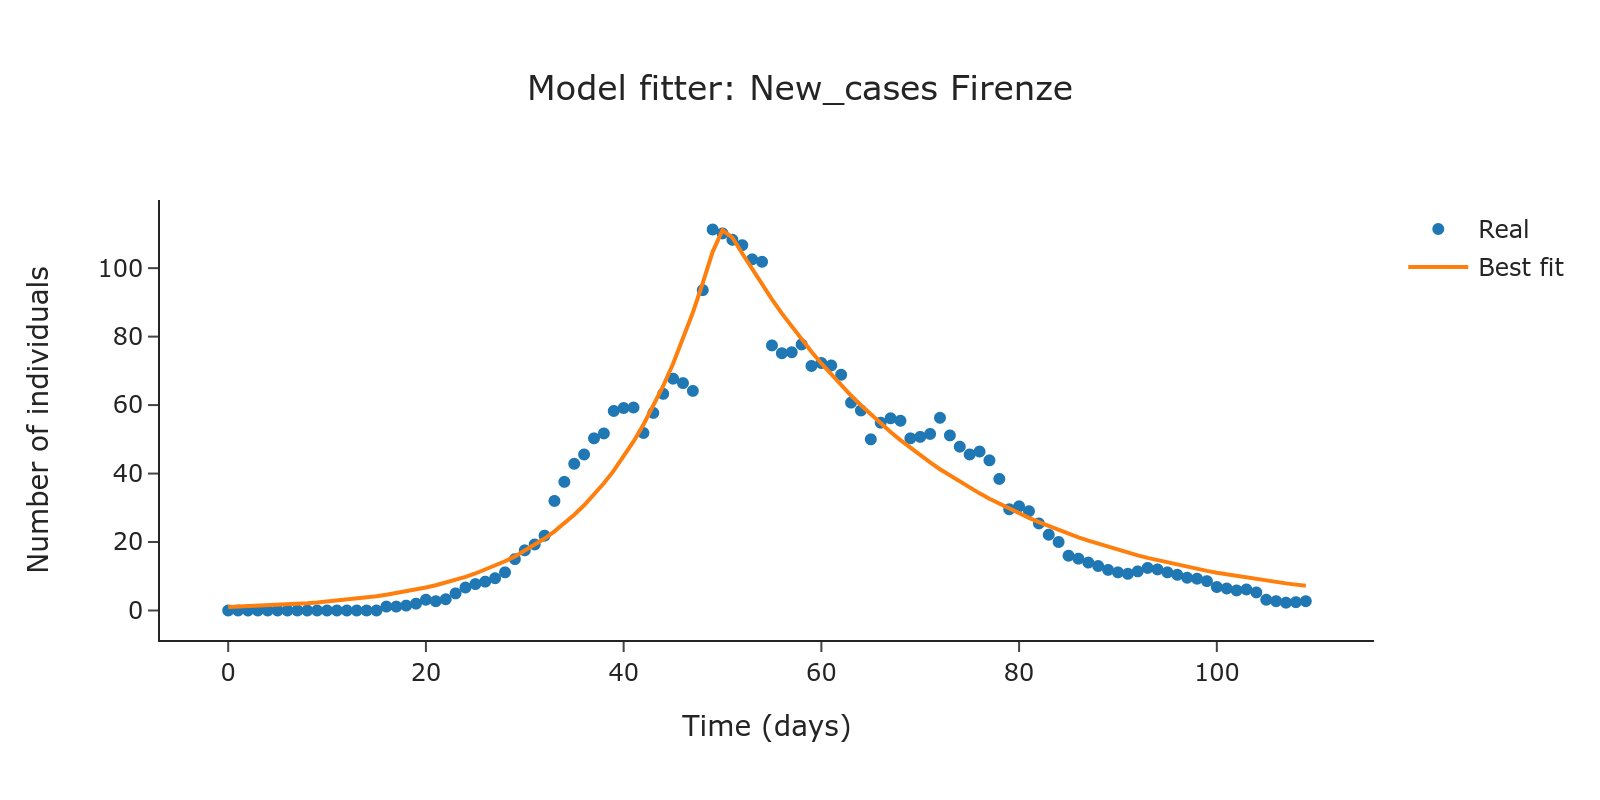

In [41]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [42]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(5.1353624823786514, 45.474908307785185)

In [43]:
result.best_values

{'R_0_start': 4.052156711003933,
 'k': 2.9326495956369127,
 'x0': 49.92463894319742,
 'R_0_end': 3.4999999963869994,
 'alpha': 0.9063199642227926,
 'gamma': 0.2530150538119541}

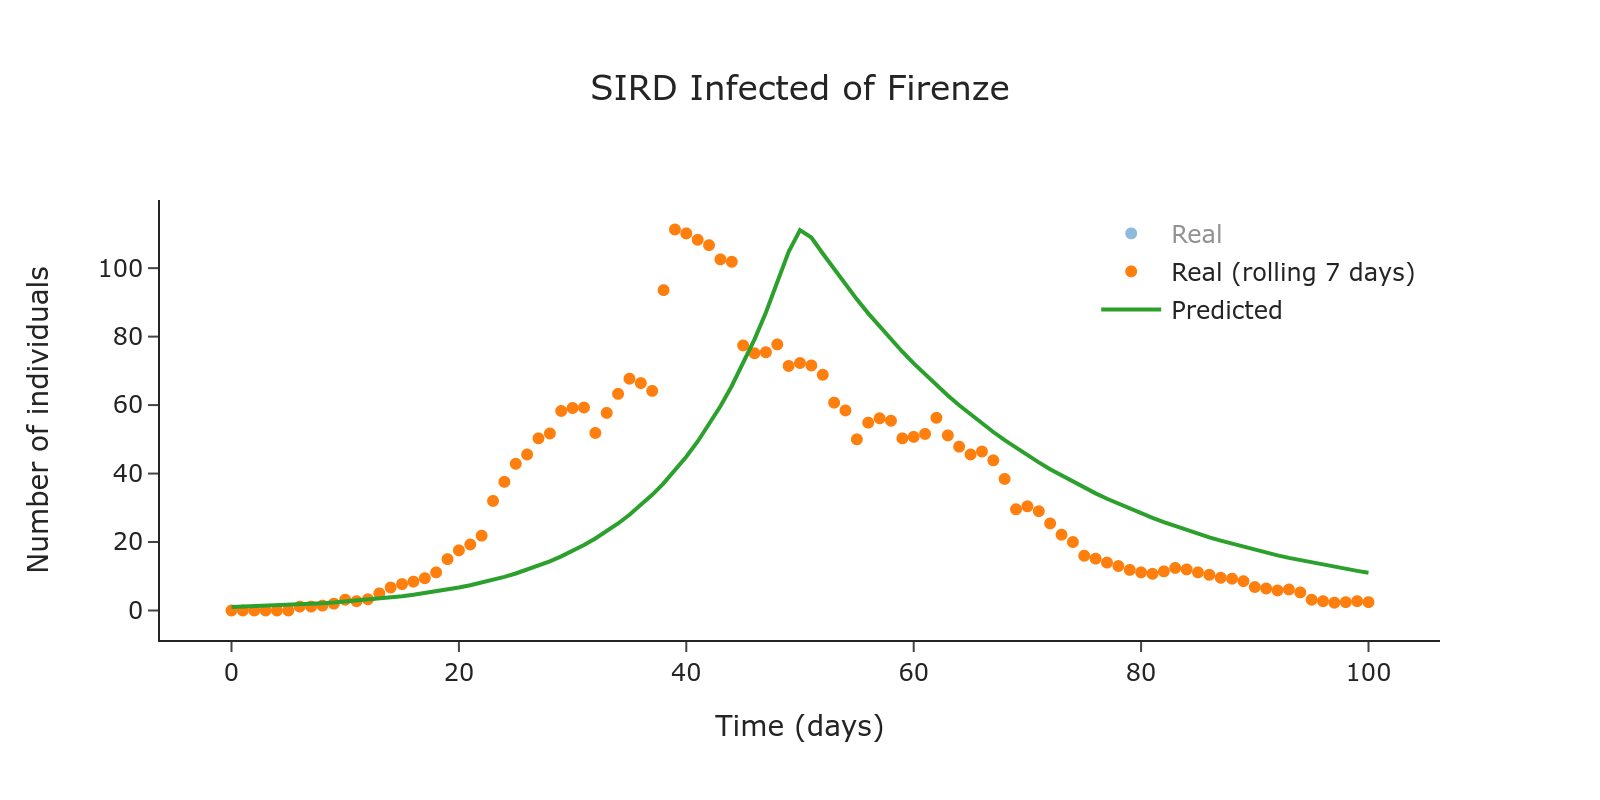

In [44]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [45]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(19.113807034585523, 613.9534468451312)

### Daily infected - Bologna
No outbreak shift

In [46]:
province = 'Bologna'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 728
    # data points      = 100
    # variables        = 6
    chi-square         = 5177.09762
    reduced chi-square = 55.0755066
    Akaike info crit   = 406.682969
    Bayesian info crit = 422.313990
[[Variables]]
    R_0_start:  3.85781475 +/- 0.77411065 (20.07%) (init = 3.5)
    k:          0.75424466 +/- 0.26522806 (35.16%) (init = 0.3)
    x0:         32.6953830 +/- 0.32227397 (0.99%) (init = 20)
    R_0_end:    3.15554101 +/- 0.46050078 (14.59%) (init = 0.9)
    alpha:      0.84599519 +/- 2.05883003 (243.36%) (init = 0.1)
    gamma:      0.27053191 +/- 0.46207082 (170.80%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma)       =  1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, alpha)   = -1.000
    C(R_0_end, alpha)     =  1.000
    C(R_0_end, gamma)     =  1.000
    C(R_0_start, R_0_end) = -1.000
    C(k, R_0_end)         =  0.261
    C(R_0_start

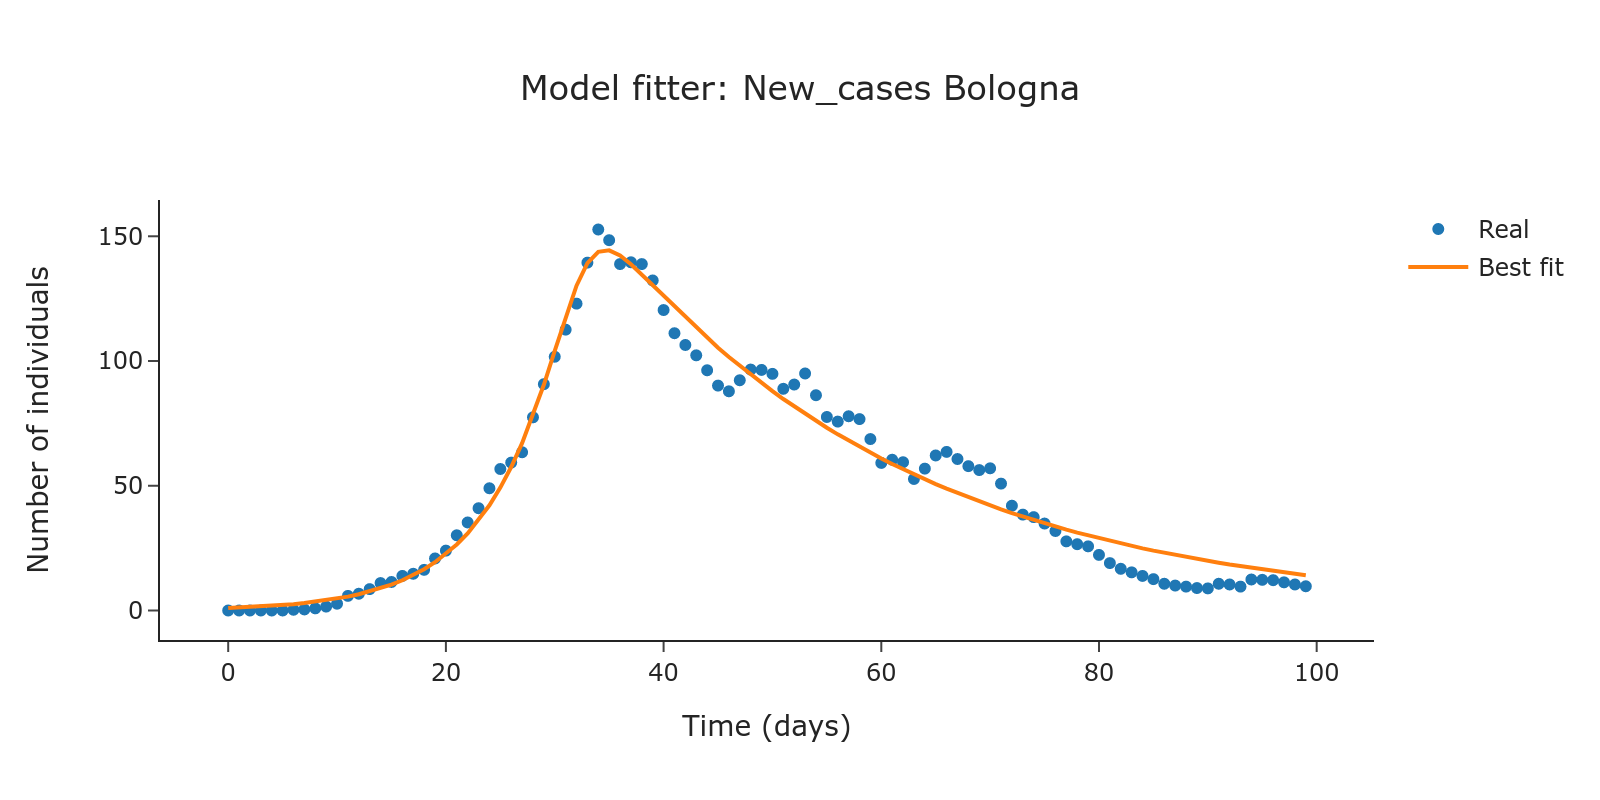

In [47]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [50]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(5.688712301757504, 51.77097619740428)

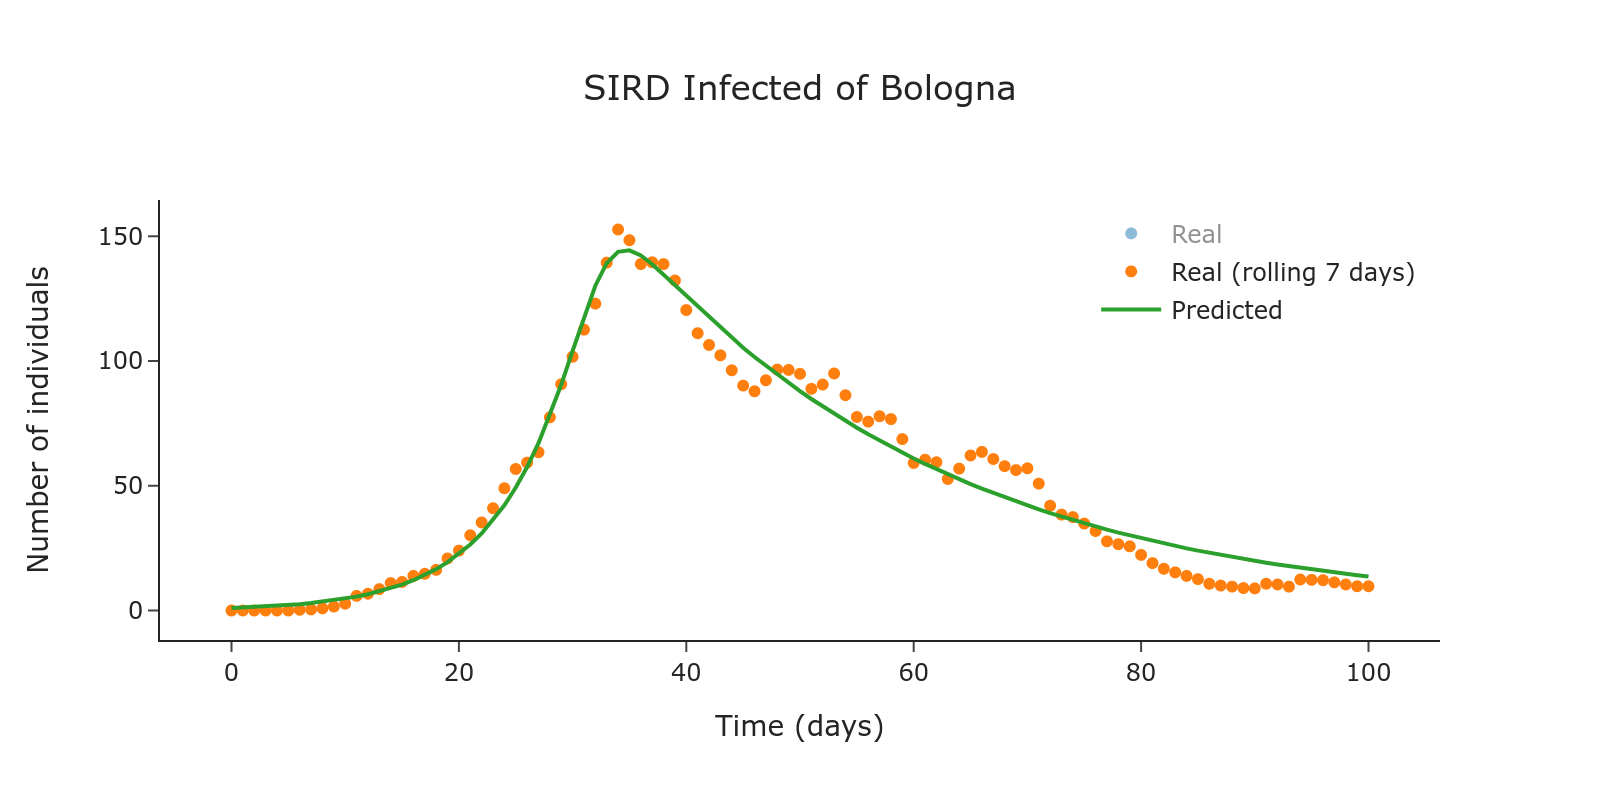

In [48]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, 'New_cases', I, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [49]:
mean_absolute_error(data[1], data[2]), mean_squared_error(data[1], data[2])

(5.671218728735603, 51.410679374153005)

### Skewed gaussian param estimation - Bologna
No outbreak shift

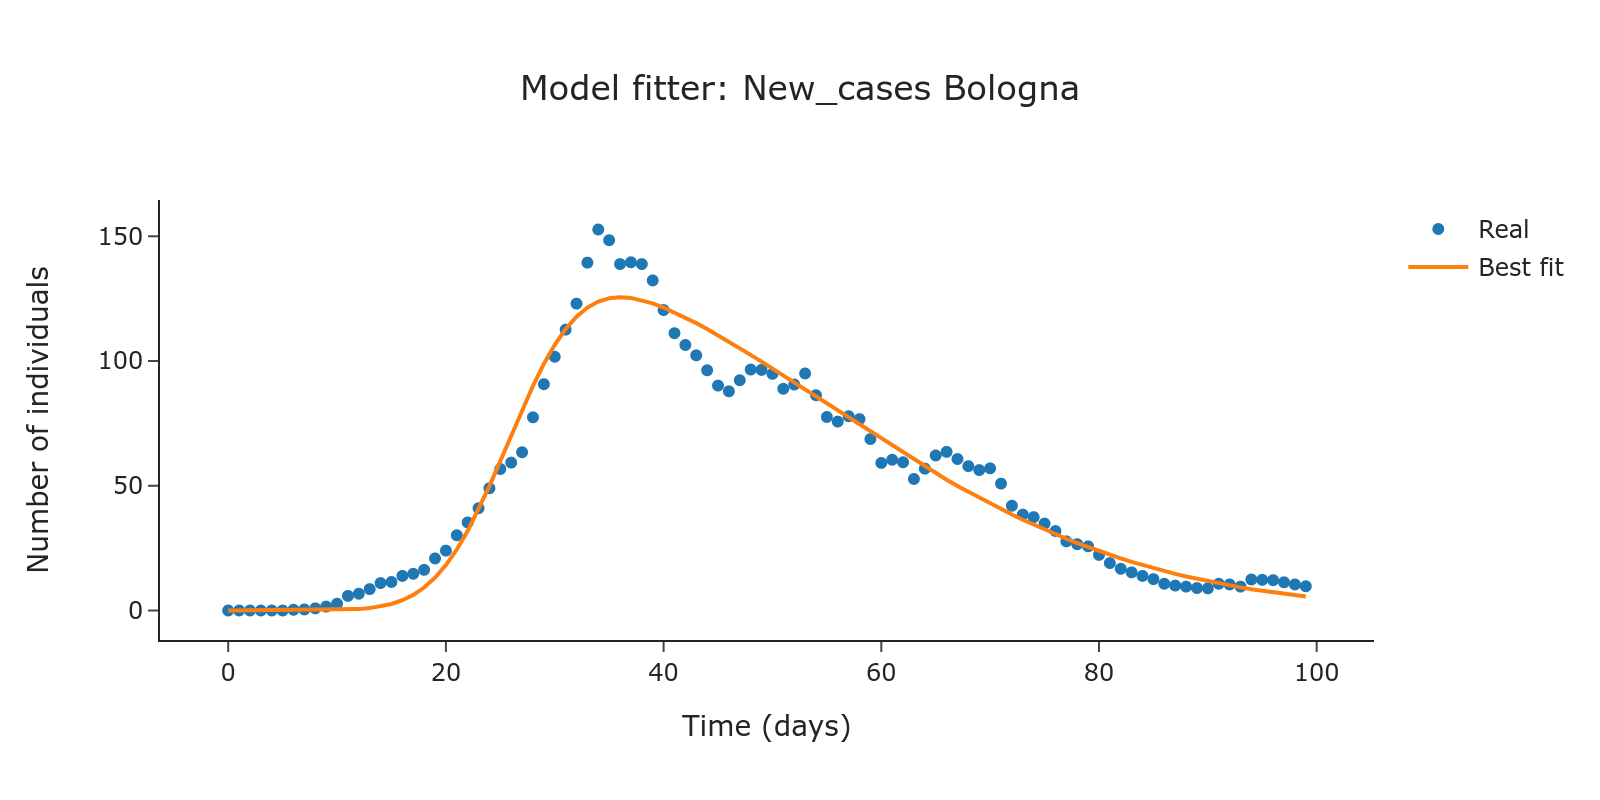

In [51]:
from lmfit.models import SkewedGaussianModel

province = 'Bologna'
compart = 'New_cases'

_, _, y_data, x_data, _, _ = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

model = SkewedGaussianModel()
params = model.guess(y_data, x=x_data)

result = model.fit(y_data, params, x=x_data)

general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [52]:
mean_absolute_error(result.data, result.best_fit), mean_squared_error(result.data, result.best_fit)

(6.034830571902737, 68.41045143333051)

In [53]:
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 100
    # variables        = 4
    chi-square         = 6841.04514
    reduced chi-square = 71.2608869
    Akaike info crit   = 430.552561
    Bayesian info crit = 440.973242
[[Variables]]
    amplitude:  4980.53084 +/- 80.1918752 (1.61%) (init = 6872.143)
    center:     25.8493059 +/- 0.30152642 (1.17%) (init = 42.56667)
    sigma:      28.9202731 +/- 0.66437112 (2.30%) (init = 15)
    gamma:      5.45079057 +/- 0.50824227 (9.32%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.591
    C(sigma, gamma)      =  0.552
    C(amplitude, sigma)  =  0.522
    C(center, gamma)     = -0.377
    C(amplitude, center) = -0.290


## Discrete SIRD
Discrete parameter estimation using LinearRegression.

Compute parameters for each day and then predict new days

In [9]:
regione = 'Piemonte'
pop = get_region_pop(regione, pop_prov_df, prov_list_df)

filtered_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

#PROVA
filtered_df = filtered_df.query('20200531 > data')

filtered_df['suscettibili'] = pop - filtered_df['totale_casi']

filtered_df = filtered_df[['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'suscettibili', 'nuovi_positivi']]

In [73]:
n = filtered_df.shape[0]

gamma = np.diff(filtered_df['dimessi_guariti'].values)/filtered_df.iloc[:n-1]['totale_positivi'].values
alpha = np.diff(filtered_df['deceduti'].values)/filtered_df.iloc[:n-1]['totale_positivi'].values
beta = (pop/filtered_df.iloc[:n-1]['suscettibili'].values)*(np.diff(filtered_df['totale_positivi'].values)+np.diff(filtered_df['dimessi_guariti'].values)+np.diff(filtered_df['deceduti'].values))/filtered_df.iloc[:n-1]['totale_positivi'].values
R0 = beta/(gamma+alpha)

In [74]:
def fix_arr(arr):
    arr[arr < 0] = 0
    arr[np.isinf(arr)] = 0
    return np.nan_to_num(arr)

gamma = fix_arr(gamma)
alpha = fix_arr(alpha)
beta = fix_arr(beta)
R0 = fix_arr(R0)

In [75]:
def lag_data(data, lag=5, return_all=False):
    N = len(data)
    X = np.empty(shape=(N-lag, lag+1))

    for i in range(lag, N):
        X[i-lag,] = [data[i-j] for j in range(lag+1)]
    
    if not return_all:
        return X[-1,1:]
    else:
        return X[:,1:], X[:,0]

In [76]:
from sklearn.linear_model import LinearRegression

lag = 7
reg_beta = LinearRegression().fit(*lag_data(beta, lag, True))
reg_gamma = LinearRegression().fit(*lag_data(gamma, lag, True))
reg_alpha = LinearRegression().fit(*lag_data(alpha, lag, True))

In [77]:
days_to_predict = 14

S = np.zeros(days_to_predict + 2)
I = np.zeros(days_to_predict + 2)
R = np.zeros(days_to_predict + 2)
D = np.zeros(days_to_predict + 2)
S[0] = filtered_df.iloc[-1]['suscettibili']
I[0] = filtered_df.iloc[-1]['totale_positivi']
R[0] = filtered_df.iloc[-1]['dimessi_guariti']
D[0] = filtered_df.iloc[-1]['deceduti']

for i in range(days_to_predict + 1):
    _beta = fix_arr(reg_beta.predict(lag_data(beta, lag).reshape(1, -1)))
    _gamma = fix_arr(reg_gamma.predict(lag_data(gamma, lag).reshape(1, -1)))
    _alpha = fix_arr(reg_alpha.predict(lag_data(alpha, lag).reshape(1, -1)))

    beta = np.append(beta, _beta, axis = 0)
    gamma = np.append(gamma, _gamma, axis = 0)
    alpha = np.append(alpha, _alpha, axis = 0)

    dIdt = np.round((1 + _beta * (S[i]/pop) - _gamma - _alpha)*I[i])
    dRdt = np.round(R[i] + _gamma * I[i])
    dDdt = np.round(D[i] + _alpha * I[i])
    dSdt = pop-dIdt[0]-dRdt[0]-dDdt[0]

    S[i+1] = dSdt
    I[i+1] = dIdt
    R[i+1] = dRdt
    D[i+1] = dDdt

S = S[1:]
I = I[1:]
R = R[1:]
D = D[1:]

In [78]:
dates = pd.date_range(start=(filtered_df.iloc[-1]['data'] + pd.DateOffset(1)).strftime('%Y-%m-%d'), periods=days_to_predict + 1)

tmp_df = pd.DataFrame(np.column_stack([np.zeros(days_to_predict + 1), I, R, D, S]),
    columns = [
        'data',
        'totale_positivi', 
        'dimessi_guariti',
        'deceduti', 
        'suscettibili'])

tmp_df['data'] = dates

In [79]:
filtered_df = pd.concat([filtered_df, tmp_df], ignore_index=True)

In [80]:
filtered_df['nuovi_positivi'] = [0]+list(np.diff(filtered_df['totale_positivi'].values)+np.diff(filtered_df['dimessi_guariti'].values)+np.diff(filtered_df['deceduti'].values))

filtered_df['nuovi_positivi'] = filtered_df['nuovi_positivi'].apply(lambda x: 0 if x < 0 else x)

beta = np.append(beta, np.zeros((1,)), axis = 0)
gamma = np.append(gamma, np.zeros((1,)), axis = 0)
alpha = np.append(alpha, np.zeros((1,)), axis = 0)

filtered_df['beta'] = beta
filtered_df['gamma'] = gamma
filtered_df['alpha'] = alpha
filtered_df['R0'] = fix_arr(beta/(gamma+alpha))
filtered_df = filtered_df[:-1]

In [81]:
filtered_df = filtered_df.astype({'totale_positivi': 'int32',
'dimessi_guariti': 'int32', 'deceduti': 'int32', 'suscettibili': 'int32', 'nuovi_positivi': 'int32'})

In [82]:
filtered_df

,data,totale_positivi,dimessi_guariti,deceduti,suscettibili,nuovi_positivi,beta,gamma,alpha,R0
0,2020-02-24,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
1,2020-02-25,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
2,2020-02-26,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
3,2020-02-27,2,0,0,4341373,0,4.500002,0.000000,0.000000,0.000000
4,2020-02-28,11,0,0,4341364,9,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
106,2020-06-09,3112,24772,4017,4309474,119,0.037502,0.094165,0.005110,0.377761
107,2020-06-10,2919,25065,4033,4309358,116,0.039899,0.094125,0.004956,0.402697
108,2020-06-11,2745,25340,4047,4309243,115,0.040422,0.095022,0.005295,0.402948
109,2020-06-12,2580,25601,4062,4309132,111,0.039411,0.103776,0.005465,0.360775


In [83]:
real_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

real_df = real_df.query('20200614 > data')

real_df['suscettibili'] = pop - real_df['totale_casi']

real_df = real_df[['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'suscettibili', 'nuovi_positivi']]

real_df

,data,totale_positivi,dimessi_guariti,deceduti,suscettibili,nuovi_positivi
13,2020-02-24,3,0,0,4341372,3
34,2020-02-25,3,0,0,4341372,0
55,2020-02-26,3,0,0,4341372,0
76,2020-02-27,2,0,0,4341373,-1
97,2020-02-28,11,0,0,4341364,9
...,...,...,...,...,...,...
2239,2020-06-09,3671,23258,3961,4310485,21
2260,2020-06-10,3372,23568,3976,4310459,26
2281,2020-06-11,3183,23787,3988,4310417,42
2302,2020-06-12,2897,24096,3996,4310386,31


In [84]:
# Run if we want to show only the real predicted points
# in the graph and not the entire line

#filtered_df['nuovi_positivi'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['nuovi_positivi'])

#filtered_df['deceduti'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['deceduti'])

#filtered_df['dimessi_guariti'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['dimessi_guariti'])

#filtered_df['totale_positivi'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['totale_positivi'])

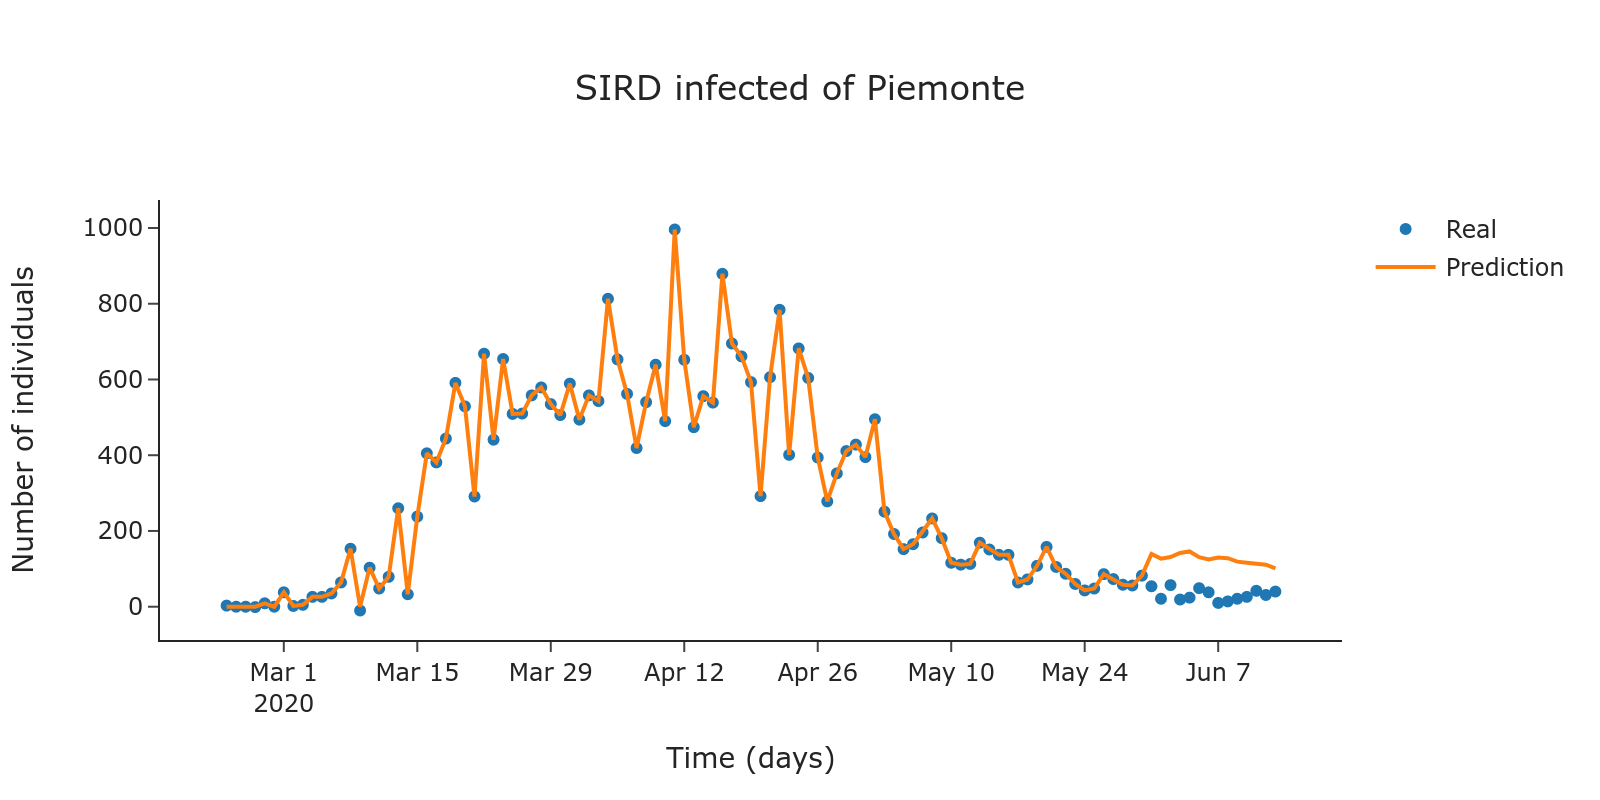

In [85]:
general_plot(t=real_df['data'],
             title='SIRD infected of ' + regione,
             data=[real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [86]:
mean_absolute_error(real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values), mean_squared_error(real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values)

(11.972972972972974, 1161.2882882882882)

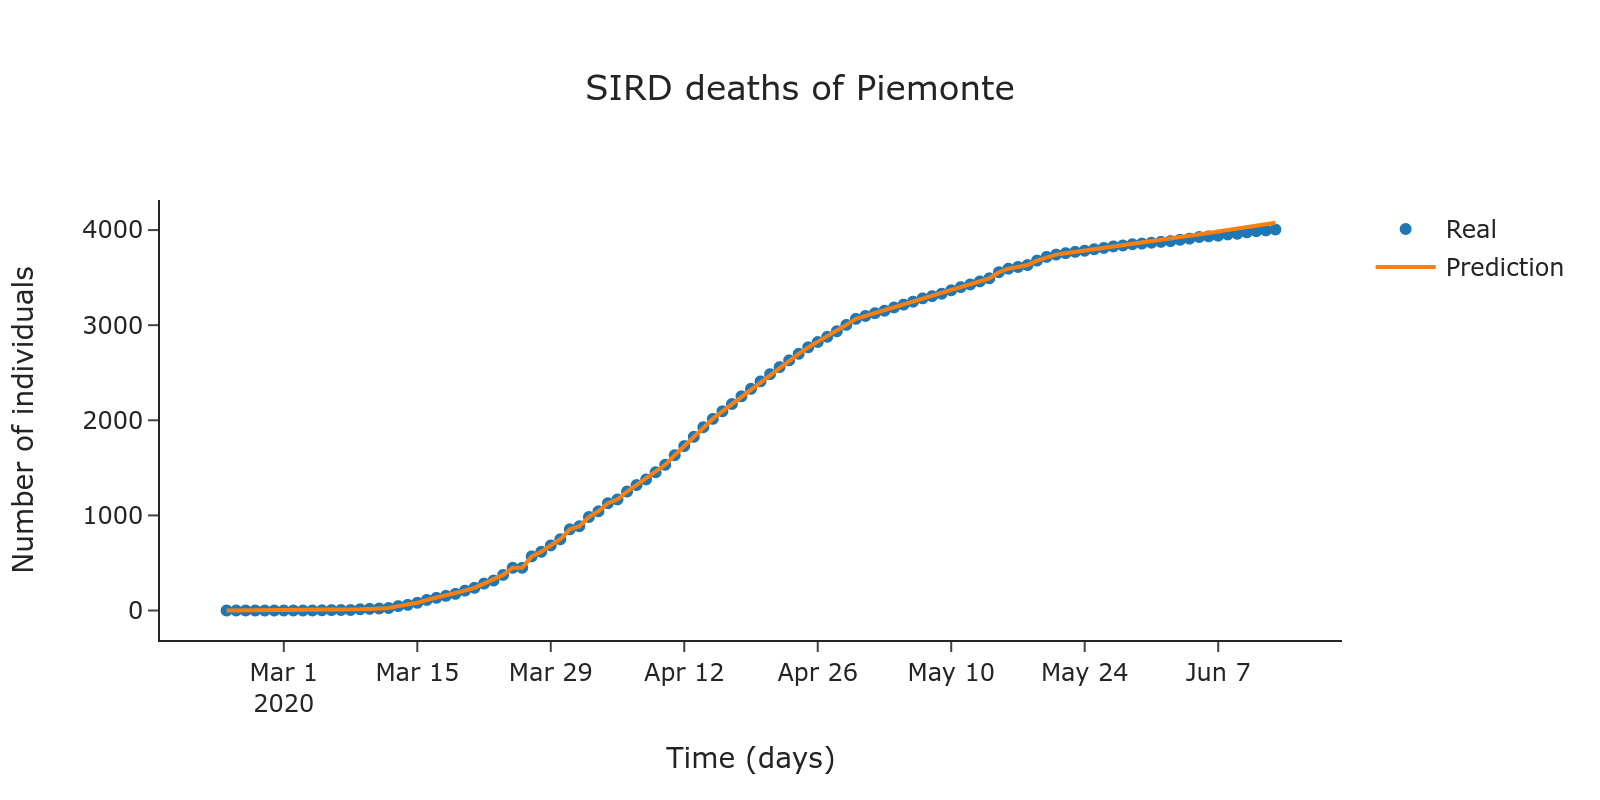

In [87]:
general_plot(t=real_df['data'],
             title='SIRD deaths of ' + regione,
             data=[real_df['deceduti'].values, filtered_df['deceduti'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [88]:
mean_absolute_error(real_df['deceduti'].values, filtered_df['deceduti'].values), mean_squared_error(real_df['deceduti'].values, filtered_df['deceduti'].values)

(4.981981981981982, 245.93693693693695)

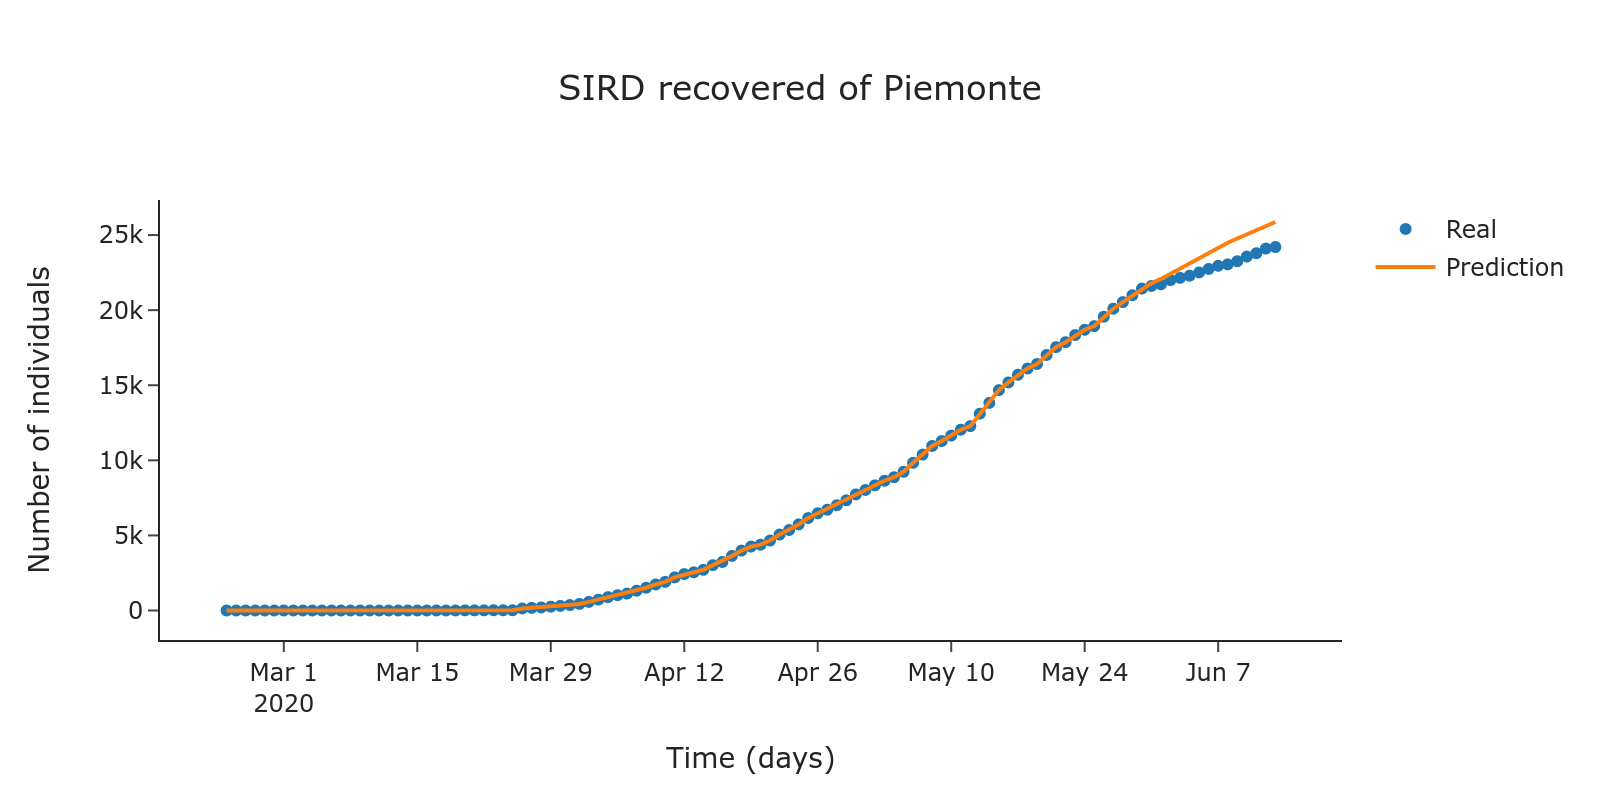

In [89]:
general_plot(t=real_df['data'],
             title='SIRD recovered of ' + regione,
             data=[real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [90]:
mean_absolute_error(real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values), mean_squared_error(real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values)

(135.97297297297297, 175774.33333333334)

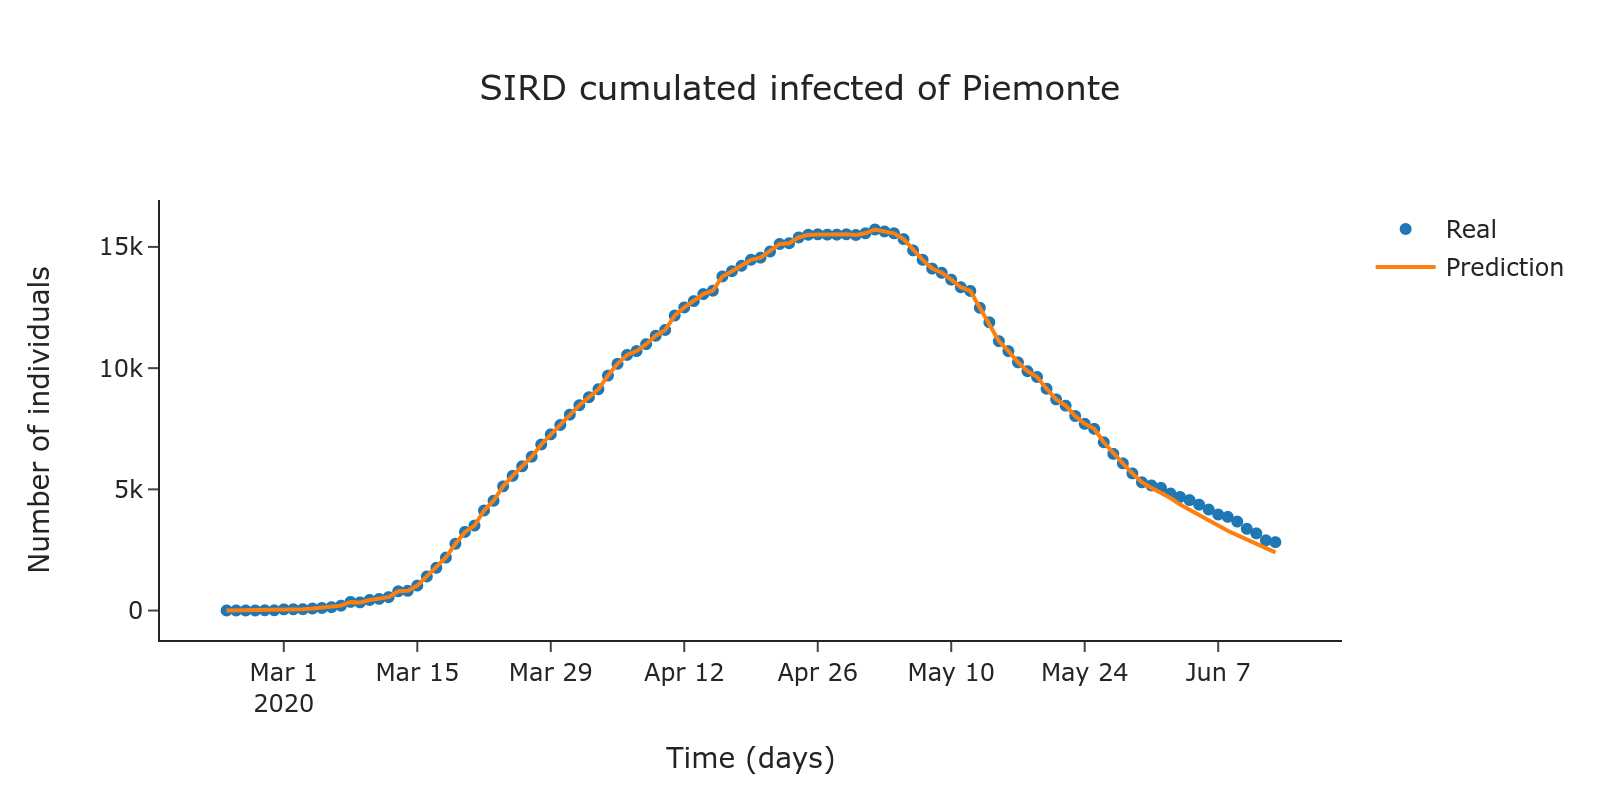

In [91]:
general_plot(t=real_df['data'],
             title='SIRD cumulated infected of ' + regione,
             data=[real_df['totale_positivi'].values, filtered_df['totale_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [92]:
mean_absolute_error(real_df['totale_positivi'].values, filtered_df['totale_positivi'].values), mean_squared_error(real_df['totale_positivi'].values, filtered_df['totale_positivi'].values)

(48.369369369369366, 21040.08108108108)

In [5]:
model = DeterministicSird(
    data_df=dpc_regioni_df, 
    pop_prov_df=pop_prov_df, 
    prov_list_df=prov_list_df, 
    regione='Piemonte', 
    group_column='denominazione_regione', 
    data_column='data', 
    data_filter='20200630', 
    lag=7, 
    days_to_predict=14)

In [6]:
res = model.fit()

In [7]:
realdata = model.real_df

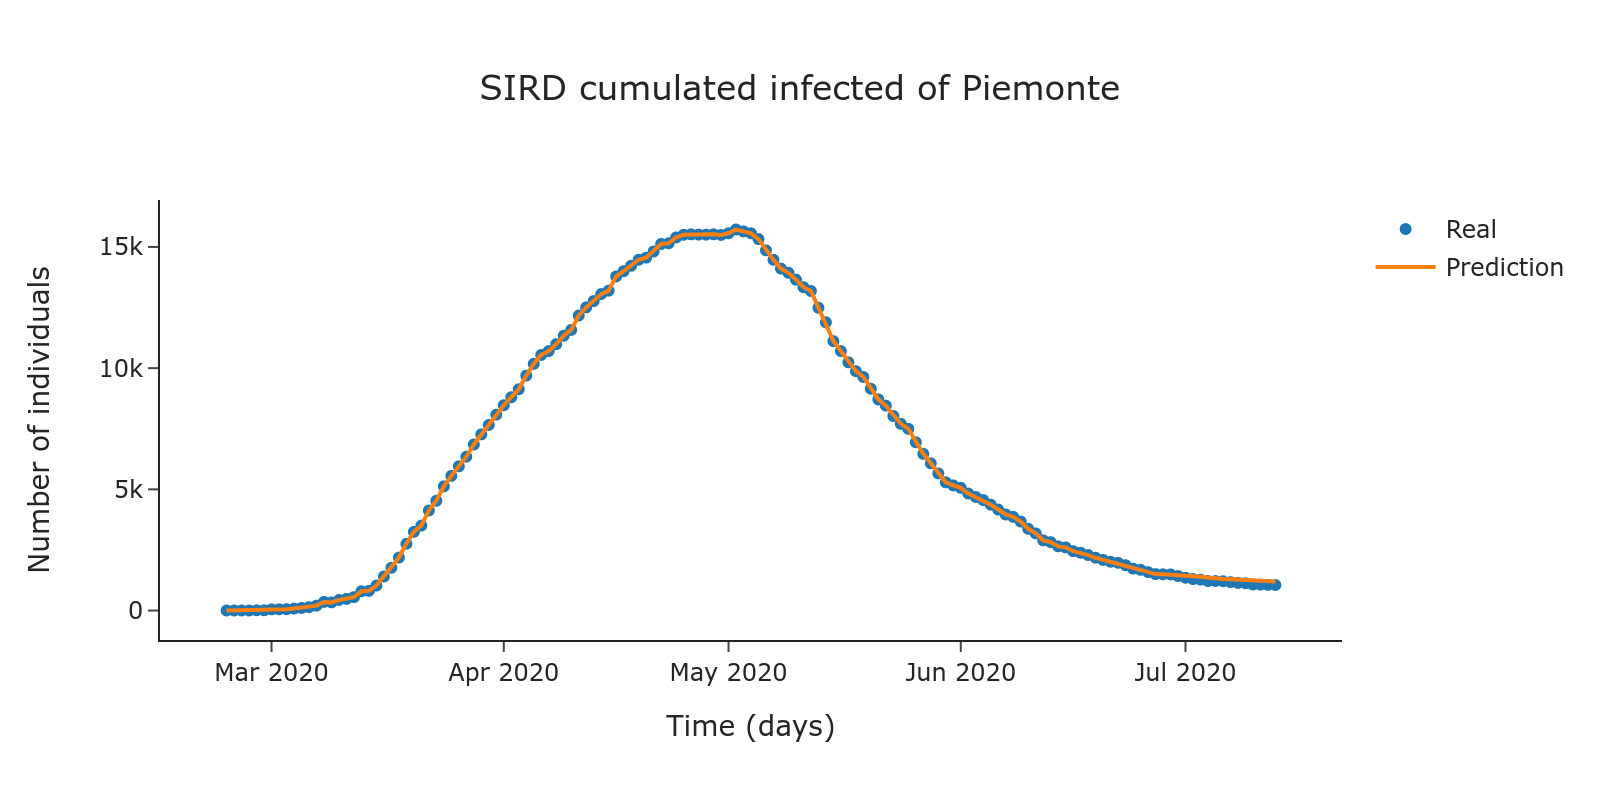

In [8]:
general_plot(t=realdata['data'],
             title='SIRD cumulated infected of ' + 'Piemonte',
             data=[realdata['totale_positivi'].values, res['totale_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [9]:
mean_absolute_error(realdata['totale_positivi'].values, res['totale_positivi'].values), mean_squared_error(realdata['totale_positivi'].values, res['totale_positivi'].values)

(12.28368794326241, 1627.404255319149)